In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

In [83]:
# Load Data
model_df = pd.read_csv('model_df.csv')

In [84]:
# Train Test Split
def tts(data):
    data = data.drop(['accidents','date'],axis=1)
    train, test = data[0:-121].values, data[-121:].values
    
    return train, test

train, test = tts(model_df)

In [85]:
train.shape

(627, 13)

In [86]:
test.shape

(121, 13)

In [87]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [88]:
y_train.shape

(627,)

In [89]:
# Modeling Functions
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [90]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('cleaned_data.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-1])
    original_df.date = original_df.date.apply(lambda x: str(x)[:11])
    original_df = original_df.groupby('date')['accidents'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [106]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted accidents
    result_list = []
    accidents_dates = list(original_df[-122:].date)
    act_accidents = list(original_df[-122:].accidents)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_accidents[index])
        result_dict['date'] = accidents_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    return df_result

In [107]:
X_train.shape

(627, 12)

In [108]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.accidents[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.accidents[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

In [109]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.accidents, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Accidents",
           title = f"{model_name} Accidents Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'{model_name}_forecast.png')

In [110]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

RMSE: 22.49814807193398
MAE: 17.5


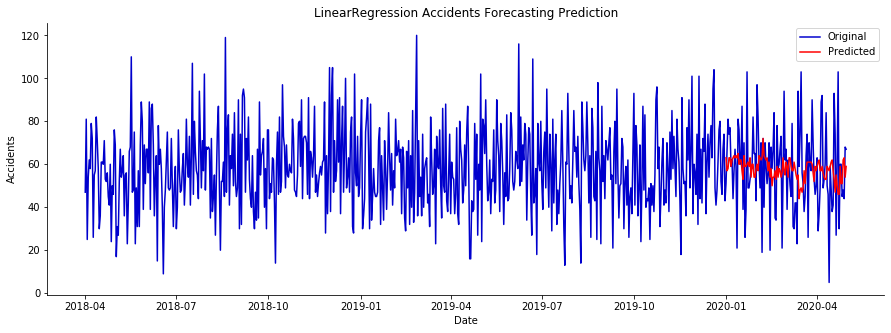

In [111]:
# Linear Regression
run_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 28.136571693556885
MAE: 22.0


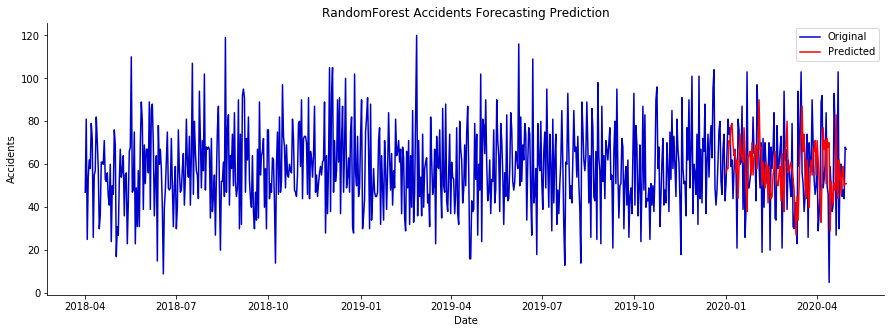

In [112]:
# Random Forest Regressor
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

RMSE: 34.03552066101923
MAE: 28.083333333333332


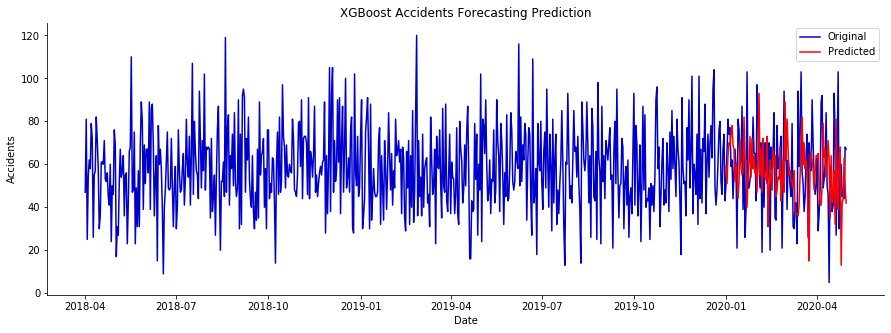

In [113]:
# XGBoost
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [114]:
# LSTM
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
627/627 [==============================] - 2s 3ms/step - loss: 0.1150A: 0s - loss:  - ETA: 0s - loss:
Epoch 2/200
627/627 [==============================] - 1s 2ms/step - loss: 0.1041A: 0s - loss: 0.
Epoch 3/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0811
Epoch 4/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0682
Epoch 5/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0646A: 0
Epoch 6/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0627A: 0s - 
Epoch 7/200
627/627 [==============================] - 2s 3ms/step - loss: 0.0614
Epoch 8/200
627/627 [==============================] - 2s 3ms/step - loss: 0.0602
Epoch 9/200
627/627 [==============================] - 3s 5ms/step - loss: 0.0592A: 0s - loss: 0.05
Epoch 10/200
627/627 [==============================] - 2s 4ms/step - loss: 0.0583
Epoch 11/200
627/627 [==============================] - 2s 3ms/step - loss: 0.0576A: 2s - loss: 0.060

627/627 [==============================] - 1s 2ms/step - loss: 0.0457A: 0s - loss: 
Epoch 95/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0456A: 0
Epoch 96/200
627/627 [==============================] - 2s 3ms/step - loss: 0.0456
Epoch 97/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0455
Epoch 98/200
627/627 [==============================] - 2s 3ms/step - loss: 0.0454A: 0
Epoch 99/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0454A: 0s -  - ETA: 0s - loss: 0.04 - ETA: 0s - loss: 0.0
Epoch 100/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0453
Epoch 101/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0453A:
Epoch 102/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0452
Epoch 103/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0451
Epoch 104/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0451
Epoch 105/200
627/

627/627 [==============================] - 1s 2ms/step - loss: 0.0420A: 0s - los
Epoch 187/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0420A: 0
Epoch 188/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0419
Epoch 189/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0419
Epoch 190/200
627/627 [==============================] - ETA: 0s - loss: 0.042 - 1s 2ms/step - loss: 0.0419
Epoch 191/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0418A: 0s - loss - ETA: 0s - loss: 0.04 - ETA: 0s - loss: 0.04 - ETA: 0s - loss: 0.0 - ETA: 0s - loss: 0.0
Epoch 192/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0418
Epoch 193/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0418A: 0s - loss: 0.042 - ETA: 0s - lo
Epoch 194/200
627/627 [==============================] - 1s 2ms/step - loss: 0.0417A: 0s - loss: 0.04 - ETA: 0s - l
Epoch 195/200
627/627 [============================

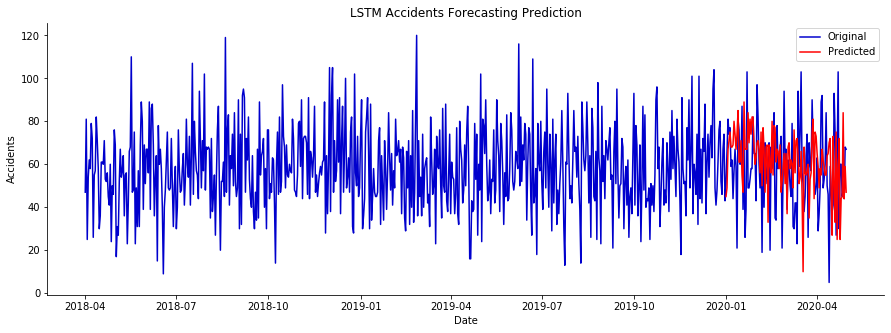

In [115]:
lstm_model(train, test)

In [116]:
pickle.dump(model_scores, open( "model_scores.p", "wb" ) )